# Loading and Cleaning Complete Dataset from lululemon's Subreddit

In this notebok, we load and clean the full dataset we acquired from lululemon's subreddit.

## Preliminaries

In [30]:
# Imports

import json
import zstandard as zstd
import pandas as pd
from dotenv import load_dotenv
import os
import io
import matplotlib.pyplot as plt
import re
import numpy as np
import time
from datetime import datetime, timezone, timedelta
from typing import Optional

In [3]:
# Set user's data path

PATH = f"C:/Users/emshe/Desktop/BRAINSTATION/LULULEMON/DATA/TORRENTED/reddit/subreddits24/lululemon_submissions"

## Helper functions 

In [4]:
# Function to clean text

def clean_text(s: str | None) -> str | None:
    
    '''
    Clean string by substituting spaces for problematic characters
    '''
    
    if s is None:
        return None
    s = re.sub(r"\s+", " ", s).strip()
    return s

In [5]:
# Function to get datetime from UTC timestamp

def dt_from_epoch(ts: Optional[int]):

    """
    Convert timestamp to pd.datetime format
    """

    
    if ts is None:
        return None
    return pd.to_datetime(ts, unit="s", utc=True)

In [6]:
# Function to examine dataframes

def examine_df(name,df,
               include_stats = True,
               include_sample = True):
    
    """
    Check basic info about a dataframe df
    """
    
    print(f"\n\nNumber of records in the {name} is: {len(df)}\n")
    print(f"\nNumber of features in the {name} is: {len(df.columns)}\n")
    print(f"The columns in the {name} are: {df.columns}\n")
    print(f"\n Other info about {name}:\n")
    display(df.info())
    if include_stats == True:
        print(f'\n Basic statistical info about {name}:\n')
        display(df.describe())
    if include_sample == True:
        print(f"\n\nSample of records in the {name}:")
        display(df.head(5))

In [13]:
# Function to get sample from text column

def get_text_samples(df: pd.DataFrame, text_col: str, n: int) -> None:

    '''
    Print n samples from a text column in a dataframe
    '''

    # Ensure pandas doesn't truncate text
    pd.set_option('display.max_colwidth', None)
    
    # Sample and print 5 full negative reviews
    print("Sample text data:\n\n")
    sample = df[text_col].sample(n)
    for i, description in enumerate(sample, 1):
        print(f"Text sample {i}:\n\n\n{description}\n\n\n")

In [27]:
# Function for categorical bar graph

def bar_graph(df: pd.DataFrame, col: str) -> None:

    """
    Generate bar graph for categorical column in a dataframe
    """

    if col not in df.columns:
        raise ValueError(f"Column '{col}' not found in dataframe")

    counts = posts_df[col].value_counts()
    
    plt.figure(figsize=(10,6))
    counts.plot(kind="bar")
    plt.title(f"Distribution of {col.title()}")
    plt.xlabel(f"{col.title()}")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [28]:
# Define function to plot histogram for numeric columns

def histogram(df: pd.DataFrame, 
             col: str,
            bins: int = 30,
             log: bool = False) -> None:
    
    """
    Generate a histogram for a numeric column in a dataframe.
    """
    
    if col not in df.columns:
        raise ValueError(f"Column '{col}' not found in dataframe")
    
    plt.figure(figsize=(8, 5))
    df[col].dropna().hist(bins=bins, edgecolor="black", log=log)
    plt.title(f"Histogram of {col.title()}")
    plt.xlabel(col.title())
    plt.ylabel("Log(Frequency)" if log else "Frequency")
    plt.tight_layout()
    plt.show()

In [26]:
# Function to load ndjson

def load_plain_ndjson(path: str, limit: Optional[int] = None) -> pd.DataFrame:
    
    """
    Load a plain-text NDJSON file line by line into a DataFrame.
    """
    
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f, start=1):
            if not line.strip():
                continue
            obj = json.loads(line)

            rows.append({
                "post_id": obj.get("id"),
                "timestamp": dt_from_epoch(obj.get("created_utc")),
                "author": obj.get("author"),
                "title": obj.get("title"),
                "text": obj.get("selftext"),
                "score": obj.get("score"),
                "num_comments": obj.get("num_comments"),
                "permalink": obj.get("permalink"),
                "subreddit": obj.get("subreddit"),
            })

            if limit and i >= limit:
                break

    return pd.DataFrame(rows)

## Load and Inspect Data

In [25]:
# Load full dataframe of posts from plain ndjson

# lulu_df = load_plain_ndjson(f"{PATH}/lululemon_submissions", limit=None)
# print(lulu_df.shape)
# lulu_df.head(3)

In [9]:
# Look at date range

print(lulu_df["timestamp"].min(), "to", lulu_df["timestamp"].max())

2012-02-24 03:20:25+00:00 to 2024-12-31 23:30:34+00:00


In [17]:
# Save to Parquet file

# lulu_df.to_parquet("lululemon_submissions_full.parquet", index=False)

In [11]:
# Read back from the parquet

lulu_df = pd.read_parquet("lululemon_submissions_full.parquet")

In [20]:
# Create copy of original dataframe

og_lulu_df = lulu_df.copy()

In [12]:
# Examine lulu dataframe

examine_df('lulu dataframe', lulu_df)



Number of records in the lulu dataframe is: 179682


Number of features in the lulu dataframe is: 9

The columns in the lulu dataframe are: Index(['post_id', 'timestamp', 'author', 'title', 'text', 'score',
       'num_comments', 'permalink', 'subreddit'],
      dtype='object')


 Other info about lulu dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179682 entries, 0 to 179681
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   post_id       179682 non-null  object             
 1   timestamp     179682 non-null  datetime64[ns, UTC]
 2   author        179682 non-null  object             
 3   title         179682 non-null  object             
 4   text          179682 non-null  object             
 5   score         179682 non-null  int64              
 6   num_comments  179682 non-null  int64              
 7   permalink     179682 non-null  object             
 8   subredd

None


 Basic statistical info about lulu dataframe:



,score,num_comments
count,179682.000000,179682.000000
mean,35.753592,11.113818
std,80.277532,25.579206
min,0.000000,0.000000
25%,1.000000,2.000000
50%,7.000000,6.000000
75%,44.000000,12.000000
max,11864.000000,1987.000000




Sample of records in the lulu dataframe:


,post_id,timestamp,author,title,text,score,num_comments,permalink,subreddit
0,q4fq0,2012-02-24 19:27:03+00:00,punnyenough,Favourite items?,Discuss and share your favourites here. :-),4,8,/r/lululemon/comments/q4fq0/favourite_items/,lululemon
1,q3j88,2012-02-24 03:20:25+00:00,punnyenough,Lululemon Addict Blog,,4,0,/r/lululemon/comments/q3j88/lululemon_addict_b...,lululemon
2,q57gx,2012-02-25 06:36:07+00:00,punnyenough,Does anyone want to be a mod?,PM me if you are interested! \nI am also think...,4,0,/r/lululemon/comments/q57gx/does_anyone_want_t...,lululemon
3,q66h5,2012-02-26 02:03:02+00:00,punnyenough,Buying a lululemon yoga mat: worth the money?,"If you do yoga, where did you buy your yoga ma...",3,2,/r/lululemon/comments/q66h5/buying_a_lululemon...,lululemon
4,u2q3y,2012-05-24 13:39:40+00:00,lululemonrocks,Groove Pants - The holy grail of Yoga Pants,,1,1,/r/lululemon/comments/u2q3y/groove_pants_the_h...,lululemon


In [37]:
# Check some sample posts

get_text_samples(lulu_df,'text',5)

Sample text data:


Text sample 1:


Happy Pi Day! 🥧 You know the drill, when posting links please post in this format:

* Item Name (Color, Color) [lululemon.com/](https://lululemon.com/)
* *Ex:* Energy bra (Black, Blue) [lululemon.com/](https://lululemon.com/)

And no affiliate links!

&amp;#x200B;

**TOPS:**

All It Take Short Sleeve Shirt (Wild Indigo) [https://shop.lululemon.com/p/tops-short-sleeve/All-It-Takes-Tee-Nulu/\_/prod9370043?color=58292](https://shop.lululemon.com/p/tops-short-sleeve/All-It-Takes-Tee-Nulu/_/prod9370043?color=58292)

Ebb to Street High Neck Tank Top (White, Velvet Dust, Powder Blue, Black) [https://shop.lululemon.com/p/women-tanks/Ebb-to-Street-High-Neck-Tank-Top/\_/prod11380255?locale=en\_US&amp;sl=US&amp;color=0002](https://shop.lululemon.com/p/women-tanks/Ebb-to-Street-High-Neck-Tank-Top/_/prod11380255?locale=en_US&amp;sl=US&amp;color=0002)

Ebb to Street Long-Sleeve Shirt (Velvet Dust) [https://shop.lululemon.com/p/tops-long-sleeve/Ebb-to-Street-Long-

## Basic Cleaning

In [21]:
# Drop missing posts

mask = (
    lulu_df["text"].notna()
    & (lulu_df["text"].str.strip() != "")
    & (~lulu_df["text"].str.lower().isin(["[removed]", "[deleted]"]))
)

lulu_df = lulu_df[mask].copy().reset_index(drop=True)

earliest = lulu_df['timestamp'].min()
latest = lulu_df['timestamp'].max()


print(f"We now have {len(lulu_df)} posts which span from {earliest} to {latest}")

We now have 60028 posts which span from 2012-02-24 19:27:03+00:00 to 2024-12-31 23:30:34+00:00


In [41]:
# Drop any fully duplicated rows

lulu_df = lulu_df.drop_duplicates().reset_index(drop=True)

print(f"There are still {len(lulu_df)} posts in the dataframe.")

There are still 60028 posts in the dataframe.


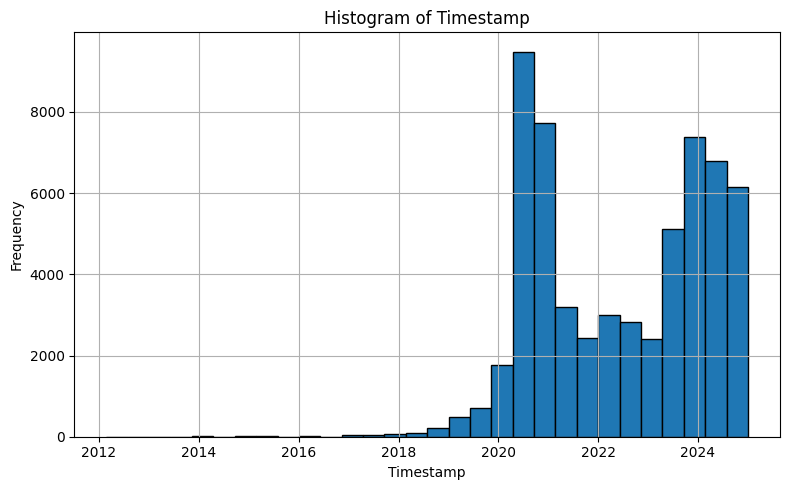

In [32]:
# Check histogram of time distribution

histogram(lulu_df, 'timestamp')

Since most older posts are missing or deleted, we restrict to the 2020s.

In [42]:
# Restrict to posts from 2020 onward

lulu_df = lulu_df[lulu_df["timestamp"].dt.year >= 2020].reset_index(drop=True)

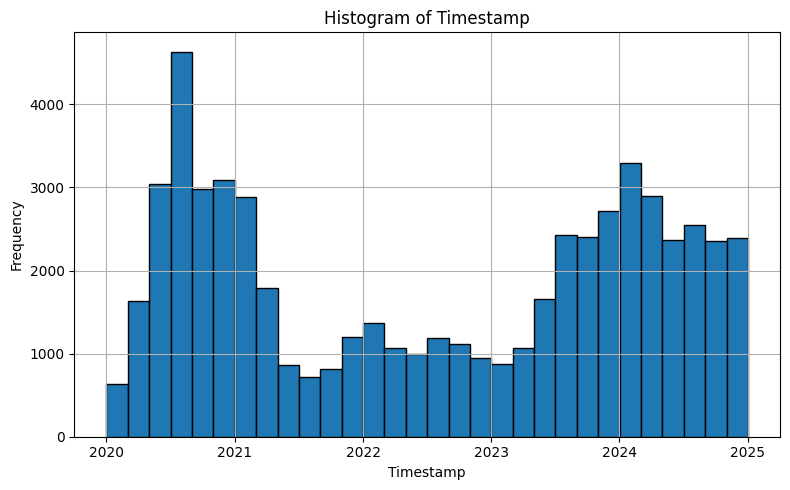

In [43]:
# Check histogram of time distribution

histogram(lulu_df, 'timestamp')

In [44]:
# Examine dataframe of posts 2020 and on

examine_df('lulu dataframe', lulu_df)



Number of records in the lulu dataframe is: 57984


Number of features in the lulu dataframe is: 9

The columns in the lulu dataframe are: Index(['post_id', 'timestamp', 'author', 'title', 'text', 'score',
       'num_comments', 'permalink', 'subreddit'],
      dtype='object')


 Other info about lulu dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57984 entries, 0 to 57983
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   post_id       57984 non-null  object             
 1   timestamp     57984 non-null  datetime64[ns, UTC]
 2   author        57984 non-null  object             
 3   title         57984 non-null  object             
 4   text          57984 non-null  object             
 5   score         57984 non-null  int64              
 6   num_comments  57984 non-null  int64              
 7   permalink     57984 non-null  object             
 8   subreddit     57984 

None


 Basic statistical info about lulu dataframe:



,score,num_comments
count,57984.000000,57984.000000
mean,23.446071,14.705126
std,87.240166,40.279924
min,0.000000,0.000000
25%,1.000000,2.000000
50%,3.000000,6.000000
75%,13.000000,13.000000
max,11864.000000,1987.000000




Sample of records in the lulu dataframe:


,post_id,timestamp,author,title,text,score,num_comments,permalink,subreddit
0,eielly,2020-01-01 05:33:25+00:00,[deleted],Monthly Sales Post- January,FS: Aligns sz 4,1,7,/r/lululemon/comments/eielly/monthly_sales_post_january/,lululemon
1,eii06s,2020-01-01 12:46:35+00:00,mimsiila,Major problem falling down leggings?,"Hello, over the last year I have been ordering lululemon stuff online as there is no store nearby. I have been trying different sizes and overall I feel their leggings are pretty bad at holding up. Especially wunder under and all the right places. I have wu in luon which is fine, and aligns are ok, new in movement seem to be ok. But align and luon get pilling issues, in movement fabric gets dust/feather sticking to it after 2 wears. In the same the luxtreme fabric in wunder under.. impossible. I don't feel i will get in the smaller size, as my thighs are huge (smaller waist). Meanwhile I tried leggings from other brands... Eg Alo yoga, very similar model (extreme high waist airlift vs super high waist wu ) and the others are performing great. In alo i have leggings in s,m and l size,none is falling. I think i am getting really disappointed. It's very addictive to shop from lululemon and they look great in the mirror, but at the same time I cannot see the worth in comfort and performance during practice (yoga, both classical and more powerful,fitness) . Am I doing something wrong? I am afraid to invest even more $$, to try more models and risk having the same flows... I am also considering redesigning WU, adding a stich or elastic band to their waist..anyone having experience with that?",0,6,/r/lululemon/comments/eii06s/major_problem_falling_down_leggings/,lululemon
2,eijtca,2020-01-01 16:00:56+00:00,brnewmeg,Tops for yoga,I have a couple swiftly tech racerbacks for hot yoga and just ordered a swiftly breeze tank because I’m wanting something with a bit more coverage (higher neckline). I find I’m adjusting my racerbacks more than I’d like in yoga but will keep wearing for hot yoga since they wick sweat so well. \n\nWhat are everyone’s favorite tops/tanks to wear for yoga? I’m a 34D so I worry about having enough coverage and not falling out of bras and tops. I have the free to be serene bra but I don’t like wearing it for yoga for this reason. Would love to find a great top (preferably a tank) that I don’t need to adjust or worry about with all the forward folds and down dogs. I knew lulu makes high neck bras but I don’t like the idea of something tight across my collarbone.,3,4,/r/lululemon/comments/eijtca/tops_for_yoga/,lululemon
3,eikiew,2020-01-01 16:59:27+00:00,vincent_n,ABC Pants - Sizing,"Hey all,\n\nI recently received ABC pants (size 32) from the store, and they fit well. However, I’ve heard from multiple friends that they lose their shape and stretch out/can become baggy after a couple of weeks-months of wear. Should I go back to the store and try a size 31 in anticipation of this? \n\nIf not, will lululemon replace these pants should they lose their shape? \n\nThanks!",1,6,/r/lululemon/comments/eikiew/abc_pants_sizing/,lululemon
4,eil4bb,2020-01-01 17:46:20+00:00,vxtoriac,Certain Aligns colours with thicker fabric?,"Hi lemonheads :D\n\nI was wondering if anyone has bought a pair of aligns that seems to be made from a thicker fabric than the usual Nulu. I think I saw a post a while ago where a few people thought their aligns were thicker, they were all dark red colour but I don't remember the exact name (not Garnet!)\n\nI recently purchased a pair of full length Aligns off Poshmark in the colour Graphite, but they also seem to be thicker, almost luon. I thought maybe they were WUs, but don't believe WUs come in that colour? I've attached a photo of the size dot (it looks real to me?), though I'm not sure how to read it or where I would check. Any advice or thoughts would be great! \n\nhttps://preview.redd.it/8zq5q04lf7841.jpg?width=3024&amp;format=pjpg&amp;auto=webp&amp;s=acaa777817edaeacc94b1effefd42b6f3d

In [45]:
# Drop irrelevant columns

irr_cols = ['author', 'permalink', 'subreddit']

lulu_df.drop(columns = irr_cols, inplace = True)

In [47]:
# Save clean data to Parquet file

lulu_df.to_parquet("lululemon_submissions_clean.parquet", index=False)